<a href="https://colab.research.google.com/github/mohamedabdelhameed711/Hand-Gesture-Classification-Using-MediaPipe-Landmarks-from-the-HaGRID-Dataset/blob/main/hand_landmarks_MLproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
! pip install numpy pandas scikit-learn matplotlib seaborn mediapipe opencv-python

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import mediapipe as mp
import cv2
from google.colab.patches import cv2_imshow

In [44]:
# Load Data
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.dropna()  # Handle missing values by dropping rows with NaNs
    return df

In [45]:
data = load_data('/content/drive/MyDrive/Colab Notebooks/hand_landmarks_data.csv')

In [46]:
data.head(5)

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [47]:
# Preprocess Data
def preprocess_data(df):

    X = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values

    # Normalize (x, y) using wrist as origin and scaling by mid-finger tip
    wrist_index = 0
    mid_finger_tip_index = 12

    for i in range(0, X.shape[1], 3):
        X[:, i] -= X[:, wrist_index]
        X[:, i+1] -= X[:, wrist_index+1]
        scale = np.linalg.norm(X[:, mid_finger_tip_index:mid_finger_tip_index+2], axis=1, keepdims=True)
        X[:, i:i+2] /= (scale + 1e-6)

    return X, y

In [48]:
X, y = preprocess_data(data)

In [49]:
print(X.shape, y.shape)

(25675, 63) (25675,)


In [50]:
# Visualize Data Distribution
def visualize_data_distribution(y):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=y)
    plt.title("Distribution of Gesture Classes")
    plt.xlabel("Gesture Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

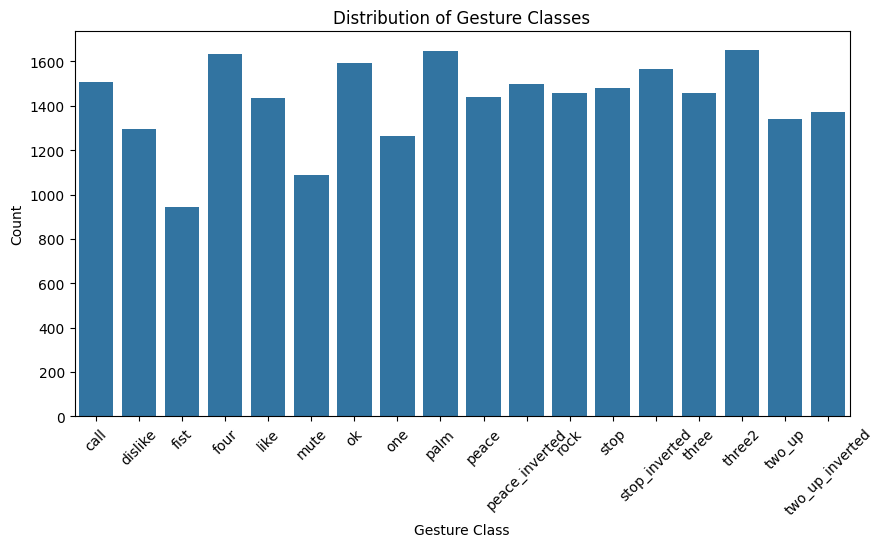

In [51]:
visualize_data_distribution(y)

In [52]:
# Split Data
def split_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

In [53]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_data(X, y)

In [54]:
# Train Models
def train_models(X_train, y_train, X_val, y_val):
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='linear', probability=True),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }

    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        val_accuracy = accuracy_score(y_val, model.predict(X_val))
        print(f"{name} Validation Accuracy: {val_accuracy:.4f}")
        trained_models[name] = model

    return trained_models

In [55]:
models = train_models(X_train, y_train, X_val, y_val)

Random Forest Validation Accuracy: 0.8376
SVM Validation Accuracy: 0.9147
KNN Validation Accuracy: 0.7004


In [56]:
# Evaluate Models
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

        print(f"{name} Performance on Test Set:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print("\n")

In [57]:
evaluate_models(models, X_test, y_test)

Random Forest Performance on Test Set:
Accuracy: 0.8209
Precision: 0.8211
Recall: 0.8209
F1-score: 0.8205


SVM Performance on Test Set:
Accuracy: 0.9128
Precision: 0.9138
Recall: 0.9128
F1-score: 0.9125


KNN Performance on Test Set:
Accuracy: 0.6939
Precision: 0.7016
Recall: 0.6939
F1-score: 0.6931




In [58]:
# Plot Hand Landmarks
# def plot_hand_landmarks(sample):
#     x_vals = sample[::3]
#     y_vals = sample[1::3]
#     plt.scatter(x_vals, -y_vals, marker='o', c='red')
#     plt.show()

In [59]:
def process_video(video_path, model, scaler):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # Replace with Output actual path
    out = cv2.VideoWriter('/content/drive/MyDrive/Colab Notebooks/output_video.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing = mp.solutions.drawing_utils
                mp_drawing.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS
                )

                # Draw landmark labels
                h, w, _ = frame.shape
                for idx, lm in enumerate(hand_landmarks.landmark):
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    cv2.putText(frame, str(idx), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

                # Extract features and predict gesture
                landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten().reshape(1, -1)
                landmarks = scaler.transform(landmarks)
                prediction = model.predict(landmarks)

                # Display predicted gesture
                cv2.putText(frame, f"Gesture: {prediction[0]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        out.write(frame)  # Save frame to video file

    cap.release()
    out.release()
    print("Video saved as output_video.mp4")


In [60]:
video_path = "/content/drive/MyDrive/Colab Notebooks/WIN_20250308_10_50_33_Pro.mp4"  # Replace with Input actual path

In [61]:
# Select the best-performing model
best_model = max(models, key=lambda name: accuracy_score(y_test, models[name].predict(X_test)))
print(f"Best performing model: {best_model}")

process_video(video_path, models[best_model], scaler)

Best performing model: SVM
Video saved as output_video.mp4


In [62]:
# from IPython.display import display, HTML

# def show_video():
#     video_path = '/content/drive/MyDrive/Colab Notebooks/output_video.mp4'
#     display(HTML(f'<video width="640" height="480" controls><source src="{video_path}" type="video/mp4"></video>'))

# show_video()
